In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
docs = ['this is a test ', 'this is also a test', 'why and I still testing this', 'ok now the test is over']


class SkipGram:
    def __init__(self, max_len=5, tokenizer=None):
        self.max_len = max_len
        self.input_len = 2
        self.tokenizer = tokenizer
        self.words = None
        self.probs = None
        self.n_words = None
        if tokenizer:
            self._setup_words()
        pass

    def _setup_words(self):
        self.n_words = sum(self.tokenizer.word_counts.values())
        self.words = np.array(list(self.tokenizer.word_counts.keys()))
        self.probs = np.array(list(self.tokenizer.word_counts.values()))/self.n_words

    def fit(self, docs):
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(docs)
        self._setup_words()

    def _text_to_padded_sequences(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len, padding='post', truncating='post')
        return seqs_padded
    def text_to_seq(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len-1, padding='post', truncating='post')
        return seqs_padded
    def _random_choice_int(self, v):
        new_word = np.random.choice(self.words, 1, p=self.probs)[0]
        output = self.tokenizer.word_index[new_word]
        if v == output:
            new_word = np.random.choice(self.words, 1, p=self.probs)[0]
            output = self.tokenizer.word_index[new_word]
        
        return output

    def _missing_word_gen(self, docs):
        seqs = self._text_to_padded_sequences(docs)
        for seq in seqs:
            seq = np.array(seq)
            if sum(seq) != 0:
                for i in range(self.input_len, self.max_len):
                    if seq[i] != 0:
                        new_seq = np.delete(seq, i)
                        x = np.array([new_seq, new_seq])
                        word_index = seq[i]
                        new_word_index = self._random_choice_int(word_index)
                        context = np.array([[word_index], [new_word_index]])
                        label = np.array([[1], [0]])
                        yield x, context, label

    def array_to_texts(self, x):
        return list(s.tokenizer.sequences_to_texts_generator(x))

    def transform(self, docs):
        array_list = list(self._missing_word_gen(docs))
        x = np.vstack([v[0] for v in array_list])
        context = np.vstack([v[1] for v in array_list])
        labels = np.vstack([v[2] for v in array_list]).flatten()
        return x, context, labels

docs = ['this is a test', 'this is still a test', 'why am I still testing', '']
s = SkipGram(max_len = 7)
s.fit(docs)
test_x, test_context, test_labels = s.transform(docs)
list(zip(s.array_to_texts(test_x,), s.array_to_texts( test_context),test_labels ))

Using TensorFlow backend.
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/py

[('this is test', 'a', 1),
 ('this is test', 'testing', 0),
 ('this is a', 'test', 1),
 ('this is a', 'this', 0),
 ('this is a test', 'still', 1),
 ('this is a test', 'is', 0),
 ('this is still test', 'a', 1),
 ('this is still test', 'test', 0),
 ('this is still a', 'test', 1),
 ('this is still a', 'testing', 0),
 ('why am still testing', 'i', 1),
 ('why am still testing', 'this', 0),
 ('why am i testing', 'still', 1),
 ('why am i testing', 'this', 0),
 ('why am i still', 'testing', 1),
 ('why am i still', 'a', 0)]

In [2]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/kamillamagna/ICD-10-CSV/master/codes.csv', header=None)
df.head()
docs = df.iloc[:, 4]

df.head()

,0,1,2,3,4,5
0,A00,0,A000,"Cholera due to Vibrio cholerae 01, biovar chol...","Cholera due to Vibrio cholerae 01, biovar chol...",Cholera
1,A00,1,A001,"Cholera due to Vibrio cholerae 01, biovar eltor","Cholera due to Vibrio cholerae 01, biovar eltor",Cholera
2,A00,9,A009,"Cholera, unspecified","Cholera, unspecified",Cholera
3,A010,0,A0100,"Typhoid fever, unspecified","Typhoid fever, unspecified",Typhoid fever
4,A010,1,A0101,Typhoid meningitis,Typhoid meningitis,Typhoid fever


In [3]:
# calculated the max sequence len
np.max([len(d.split(' ')) for d in docs])

31

In [4]:
max_len = 31
s = SkipGram(max_len=max_len)
s.fit(docs)
x, context, labels = s.transform(docs)

In [5]:
list(zip(s.array_to_texts(x[0:10,:]), s.array_to_texts(context[0:10,:]), labels[0:10] ))

[('cholera due vibrio cholerae 01 biovar cholerae', 'to', 1),
 ('cholera due vibrio cholerae 01 biovar cholerae', 'vein', 0),
 ('cholera due to cholerae 01 biovar cholerae', 'vibrio', 1),
 ('cholera due to cholerae 01 biovar cholerae', 'hostilities', 0),
 ('cholera due to vibrio 01 biovar cholerae', 'cholerae', 1),
 ('cholera due to vibrio 01 biovar cholerae', 'applicable', 0),
 ('cholera due to vibrio cholerae biovar cholerae', '01', 1),
 ('cholera due to vibrio cholerae biovar cholerae', 'at', 0),
 ('cholera due to vibrio cholerae 01 cholerae', 'biovar', 1),
 ('cholera due to vibrio cholerae 01 cholerae', 'fascia', 0)]

In [6]:
x.shape, context.shape, labels.shape

((1209416, 30), (1209416, 1), (1209416,))

In [7]:
len(s.tokenizer.word_index)


7122

In [8]:

from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Flatten, Dense, BatchNormalization
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from keras.callbacks import EarlyStopping
esm =  EarlyStopping(patience=2, monitor='loss')
input_len = x.shape[1]
vocab_size = len(s.tokenizer.word_index) + 1

dim_embedddings =10

# inputs
w_inputs = Input(shape=(input_len, ), dtype='int32')
w = Embedding(vocab_size, dim_embedddings,name= 'embx')(w_inputs)

# context
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(vocab_size, dim_embedddings, name= 'embc')(c_inputs)
o = Dot(axes=2)([w, c])
o = BatchNormalization()(o)
o = Reshape((1,input_len), input_shape=(input_len, 1))(o)
o = Flatten(name='flatten')(o)
o = Dense(1)(o)
o = Activation('sigmoid')(o)

model = Model(inputs=[w_inputs, c_inputs], outputs=o)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
# fit the model


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embx (Embedding)                (None, 30, 10)       71230       input_1[0][0]                    
__________________________________________________________________________________________________
embc (Embedding)                (None, 1, 10)        71230       input_2[0][0]                    
____________________________________________________________________________________________

In [9]:
model.fit([x, context], labels, batch_size=512, epochs=20, callbacks=[esm ])


Epoch 1/20
1209416/1209416 [==============================] - 8s 6us/step - loss: 0.3111
Epoch 2/20
1209416/1209416 [==============================] - 8s 6us/step - loss: 0.1471
Epoch 3/20
1209416/1209416 [==============================] - 8s 7us/step - loss: 0.1132
Epoch 4/20
1209416/1209416 [==============================] - 8s 7us/step - loss: 0.0986
Epoch 5/20
1209416/1209416 [==============================] - 8s 7us/step - loss: 0.0904
Epoch 6/20
1209416/1209416 [==============================] - 8s 7us/step - loss: 0.0847
Epoch 7/20
1209416/1209416 [==============================] - 8s 6us/step - loss: 0.0808
Epoch 8/20
1209416/1209416 [==============================] - 9s 7us/step - loss: 0.0776
Epoch 9/20
1209416/1209416 [==============================] - 8s 7us/step - loss: 0.0750
Epoch 10/20
1209416/1209416 [==============================] - 8s 7us/step - loss: 0.0730
Epoch 11/20
1209416/1209416 [==============================] - 8s 7us/step - loss: 0.0713
Epoch 12/20
120941

In [10]:
emb_input = Input(shape=(input_len, ), dtype='int32')
emb_layer = model.get_layer('embx')(emb_input )
emb_model = Model(inputs=emb_input, outputs=emb_layer)

seqs = s.text_to_seq(docs)
seqs[1:3]

array([[3755,   55,   21, 3128, 3756, 4291, 4292, 4863,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [3755,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [11]:
vects = emb_model.predict(seqs)
vects.shape

(71704, 30, 10)

In [12]:
vecs_reshape = np.reshape(vects, (vects.shape[0], -1))
vecs_reshape.shape

(71704, 300)

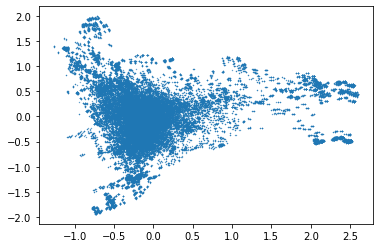

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
p = PCA(2).fit(vecs_reshape)
comps = p.transform(vecs_reshape)
xx = comps[:, 0]
yy = comps[:, 1]
plt.scatter(xx, yy,s=.1)
plt.show()

In [14]:
from keras.layers import GaussianNoise
ac_inputs = Input(shape=(30,10), dtype='float32')
ac_flat = Flatten()(ac_inputs)
ac_dense0 = Dense(30, name='d0')(ac_flat)
ac_noise = GaussianNoise(1)(ac_dense0)
ac_dense1 = Dense(300)(ac_noise) 
ac_reshape = Reshape((30,10))(ac_dense1)
ac_outputs = Activation('linear')(ac_reshape)

ae = Model(inputs=ac_inputs, outputs=ac_outputs)
ae.summary()
ae.compile(loss='mse', optimizer='adam')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30, 10)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
d0 (Dense)                   (None, 30)                9030      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               9300      
_________________________________________________________________
reshape_2 (Reshape)          (None, 30, 10)            0         
_________________________________________________________________
activation_2 (Activation)    (None, 30, 10)            0   

In [15]:
ae.fit(vects, vects, epochs=10, callbacks=[esm])

Epoch 1/10
71704/71704 [==============================] - 2s 33us/step - loss: 0.0203
Epoch 2/10
71704/71704 [==============================] - 2s 31us/step - loss: 0.0119
Epoch 3/10
71704/71704 [==============================] - 2s 31us/step - loss: 0.0099
Epoch 4/10
71704/71704 [==============================] - 2s 31us/step - loss: 0.0093
Epoch 5/10
71704/71704 [==============================] - 2s 32us/step - loss: 0.0091
Epoch 6/10
71704/71704 [==============================] - 3s 35us/step - loss: 0.0090
Epoch 7/10
71704/71704 [==============================] - 2s 35us/step - loss: 0.0090
Epoch 8/10
71704/71704 [==============================] - 2s 32us/step - loss: 0.0089
Epoch 9/10
71704/71704 [==============================] - 2s 31us/step - loss: 0.0089
Epoch 10/10
71704/71704 [==============================] - 2s 30us/step - loss: 0.0089


In [21]:
# create the final doc to vect transformer
d2v_in = Input(shape=(input_len, ), dtype='int32')
d2v__emb_layer = model.get_layer('embx')(d2v_in)
d2v_flat = Flatten()(d2v__emb_layer)
d2v_output = ae.get_layer('d0')(d2v_flat )

d2v = Model(inputs=d2v_in, outputs=d2v_output )

doc_vects = d2v.predict(seqs)
doc_vects.shape
doc_vects[1:10]


array([[ 4.4689512e+00,  5.9348524e-01, -7.4419343e-01, -6.4438260e-01,
        -3.5305054e+00, -8.2384163e-01, -2.6100132e+00,  2.1817324e+00,
         2.3164525e+00,  2.1183941e+00, -4.9767666e+00,  1.1692721e+00,
        -2.4096584e+00, -7.1553993e-01, -2.5239987e+00, -3.9288428e+00,
        -3.0476904e-01,  5.3536749e+00,  1.9736573e+00, -1.9078090e+00,
         1.0326308e+00, -2.6481221e+00,  3.1815594e-01, -1.3205260e-02,
        -3.0261903e+00,  1.0059192e+00, -2.9451082e+00, -3.7612348e+00,
        -1.0581744e+00,  2.4779454e-01],
       [ 1.4485455e+00,  1.7111412e+00,  1.2572498e+00, -8.8142365e-02,
        -6.2799942e-01,  2.0969918e+00,  2.7410865e-02,  1.7864659e+00,
         7.1183234e-02,  6.9277191e-01,  4.7176734e-01, -4.5649642e-01,
        -1.0787007e-01,  5.7616866e-01,  1.8524522e+00,  1.1788481e+00,
         1.2905182e-01,  3.8692102e-01, -8.7651300e-01,  3.7038007e-01,
         1.0046599e+00, -1.5126052e+00, -4.3586183e-02,  1.2756923e-01,
        -1.4057977e+00,